# computing pairwise distance with GPU

The goal of this exercice is to compute pairwise distances among a set of $n$-dimensional vectors.


### What CPU and GPU am I using?

Before we start, lets check what processor and GPU we will be using. Performance can vary a lot depending on which model we are using. Google Collab does not allow us to choose the model, but it is free.

In [1]:
!echo "CPU:"
!cat /proc/cpuinfo | grep name
!echo "GPU:"
!nvidia-smi

CPU:
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU:
Mon Feb 10 14:11:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         

## CPU implementation

We provide a standard Python implementation for reference.

In [2]:
from numpy.random import seed
from numpy.random import random

## code to generate a random set of m points in n dimensions
m = 5
n = 3

small_data = random((m , n))
small_data

array([[0.08863928, 0.41899976, 0.73475857],
       [0.03328103, 0.44333738, 0.75311547],
       [0.1073984 , 0.56123275, 0.10522174],
       [0.29097898, 0.96395554, 0.94905049],
       [0.1164677 , 0.01812269, 0.13508641]])

In [3]:
## scipy implementation
from scipy.spatial.distance import pdist,squareform

D_scipy = squareform( pdist(small_data) )
D_scipy

array([[0.        , 0.06319677, 0.64567696, 0.61954757, 0.72186116],
       [0.06319677, 0.        , 0.66269071, 0.61305957, 0.75477644],
       [0.64567696, 0.66269071, 0.        , 0.95285593, 0.54400614],
       [0.61954757, 0.61305957, 0.95285593, 0.        , 1.25999662],
       [0.72186116, 0.75477644, 0.54400614, 1.25999662, 0.        ]])

In [4]:
## simple numba cpu implementation
from numba import jit,njit,prange,cuda, types, float32
import numpy as np

@njit(parallel = True)
def pairwise_dist( points ):
    """
    Takes:
        - points : np.array  of dimension m x n
                    - m: number of points
                    - n: number of dimensions
    Returns:
        m x m euclidean distance matrix
    """
    nb_points = points.shape[0]
    nb_dims = points.shape[1]

    D = np.zeros((nb_points,nb_points))

    for i in prange(nb_points):
        for j in range(nb_points):

            d = 0

            for k in range(nb_dims):

                d += (points[i,k] - points[j,k])**2

            D[i,j] = d**0.5


    return D


D_cpu = pairwise_dist( small_data )
D_cpu

array([[0.        , 0.06319677, 0.64567696, 0.61954757, 0.72186116],
       [0.06319677, 0.        , 0.66269071, 0.61305957, 0.75477644],
       [0.64567696, 0.66269071, 0.        , 0.95285593, 0.54400614],
       [0.61954757, 0.61305957, 0.95285593, 0.        , 1.25999662],
       [0.72186116, 0.75477644, 0.54400614, 1.25999662, 0.        ]])

In [5]:
## we check that the two methods give the same results
np.all(D_scipy == D_cpu)

True

The complexity is linear with the number of dimension generated, and square with the number of points.

Therefore here we use a larger number of points and dimensions to increase the execution time.

In [6]:
# timing the estimate with a bigger dataset
m = 2000
n = 1000
data = random((m , n))

## scipy
%time D_scipy = squareform( pdist(data) )

## numba
%time D_cpu = pairwise_dist( data )

np.all( D_scipy == D_cpu )

CPU times: user 1.11 s, sys: 49.3 ms, total: 1.16 s
Wall time: 1.18 s
CPU times: user 5.36 s, sys: 115 ms, total: 5.47 s
Wall time: 4.19 s


True

## The CUDA implementation

Now it's your turn to implement the CUDA kernel!



In [30]:
import math

@cuda.jit
def pairwise_dist_gpu( points , distance_matrix , nb_points, nb_dim ):
    ## compute the distance between 2 points
    ## determined by the position within the grid
    i=cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
    j=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x

    if i >= nb_points or j >= nb_points:
        return

    d = 0
    for k in range(nb_dim):
      d += (points[i,k] - points[j,k])**2
    distance_matrix[i,j] = d**0.5



# calling the function
nb_points, nb_dim = data.shape

TPB = 32
blocksize = (TPB,TPB)# block size = number of threads per block dimension
gridsize = math.ceil( nb_points/TPB ) , math.ceil( nb_points/TPB )  # grid size = number of blocks per grid dimension

# Check!
D_gpu = np.zeros( (nb_points,nb_points) )

pairwise_dist_gpu[gridsize, blocksize]( data , D_gpu , nb_points, nb_dim )

np.allclose( D_gpu , D_scipy )

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


True

Now, time your function:

In [33]:
D_gpu = np.zeros( (nb_points,nb_points) )


%time D_scipy = squareform( pdist(data) )

%time pairwise_dist_gpu[gridsize, blocksize]( data , D_gpu , nb_points, nb_dim )


CPU times: user 887 ms, sys: 5.48 ms, total: 893 ms
Wall time: 888 ms
CPU times: user 254 ms, sys: 30.9 ms, total: 285 ms
Wall time: 282 ms


In [43]:
## let's keep the number of dimension constant and increase the number of points
from time import time

n = 1000

cpu_times = []
gpu_times = []
nb_points = []
for m in np.arange(100,5000,100):
  nb_points.append(m)

  data = random((m , n))


  ## cpu implementation
  t0 = time()
  D_scipy = squareform( pdist(data) )
  cpu_times.append( time()-t0 )

  ## gpu implementation
  t0 = time()

  TPB = 32
  blocksize = (TPB,TPB)# block size = number of threads per block dimension
  gridsize = math.ceil( m/TPB ) , math.ceil( m/TPB )  # grid size = number of blocks per grid dimension

  # Check!
  D_gpu = np.zeros( (m,m) )

  pairwise_dist_gpu[gridsize, blocksize]( data , D_gpu , m, n )

  gpu_times.append( time()-t0 )




Text(0, 0.5, 'execution time (s)')

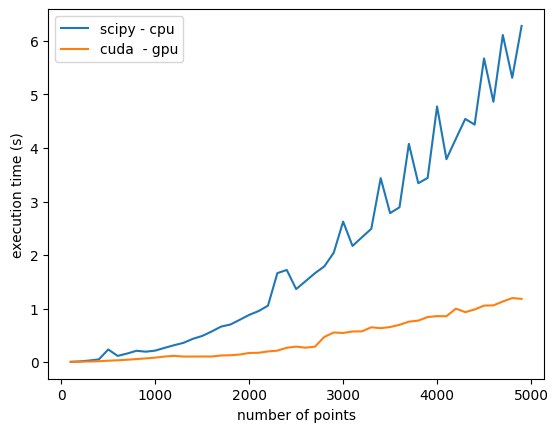

In [44]:
import matplotlib.pyplot as plt
plt.plot( nb_points , cpu_times , label ='scipy - cpu' )
plt.plot( nb_points , gpu_times , label ='cuda  - gpu' )
plt.legend()
plt.xlabel("number of points")
plt.ylabel("execution time (s)")
